# Chargement

* 96 noeuds
* 180 kr(2s), 360s=6min
* cs = Te.data2array('/home/golos/Main/TimeCourses/Amanda/29150_emp.mat')['Connectivity']
* tc = Te.data2array('/home/golos/Main/TimeCourses/Amanda/29150_emp.mat')['Data']

In [1]:
KS = array(['150', '152', '155', '157', '170', '172', '181', '186', '188', '191', '193', '197', '198', '199', '206', '208', '218', '220', '225',
            '226', '227', '228', '230', '231', '232', '233', '234', '235', '237', '241', '243', '246', '248', '251', '253', '254'], dtype='|S4')

In [2]:
AT = {}
for k in KS:
    AT[k] = Te.data2array('/home/golos/Main/TimeCourses/Amanda/29%s_emp.mat'%k)['Data'].T

# Test

In [4]:
Sit = AT['157'].T
Gt = Sit.mean(0)[newaxis]
Bi = Sit.dot( dot( inv(dot(Gt.T, Gt)) , Gt.T))
Xit = Sit - dot(Bi, Gt)
Yit = Sit - Gt
print 'Bi mean = 1 ? → %.3e'%Bi.mean()
print 'Xit sum(N) = 0 ? → %.3e'%abs(Xit.mean(0)).mean()
print 'Yit sum(N) = 0 ? → %.3e'%abs(Yit.mean(0)).mean()

Bi mean = 1 ? → 8.047e+01
Xit sum(N) = 0 ? → 1.057e+03
Yit sum(N) = 0 ? → 1.138e-15


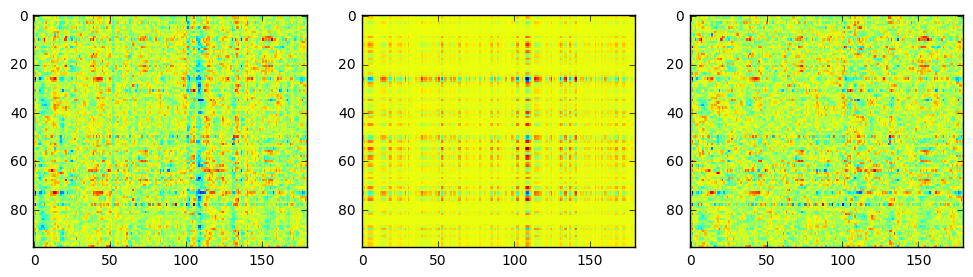

In [173]:
Td.mapMatrices([Sit, Xit, Yit], aspect='auto', fs=(12,3), interpolation='nearest', lign=1)

# Filtrage

In [5]:
ATR, ATF = {}, {}
for k in KS:
    ATR[k] = AT[k] - AT[k].mean(0)
    ATF[k] = Tp.butterBandPassFilter(ATR[k].T, 0.01, 0.1, 1./2).T

,
,
,

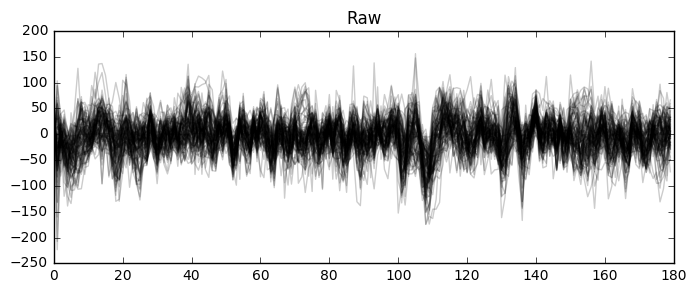
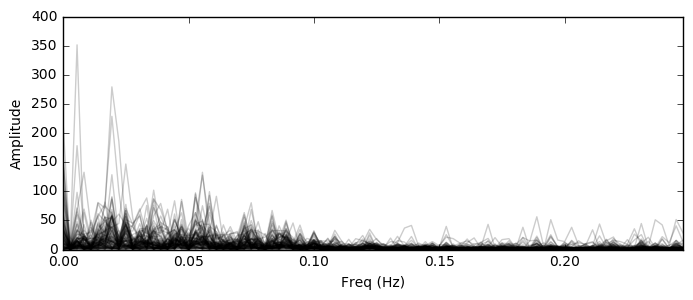
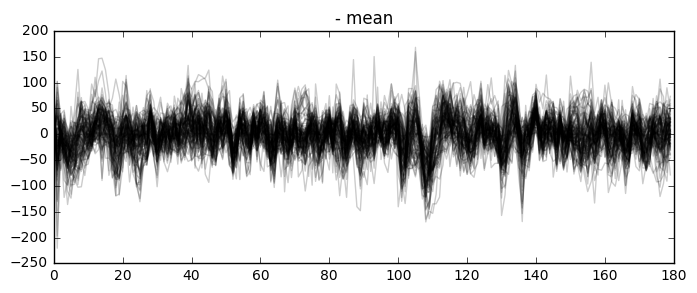
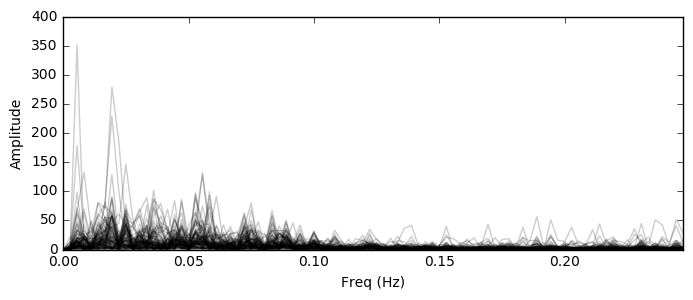
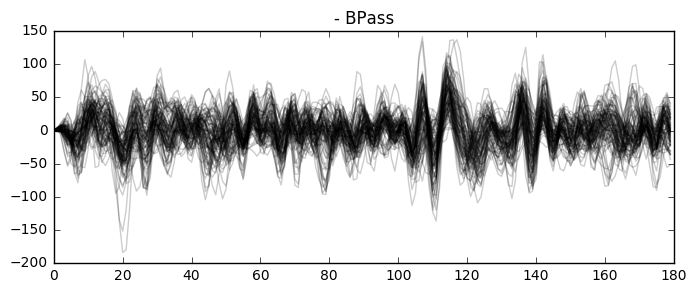
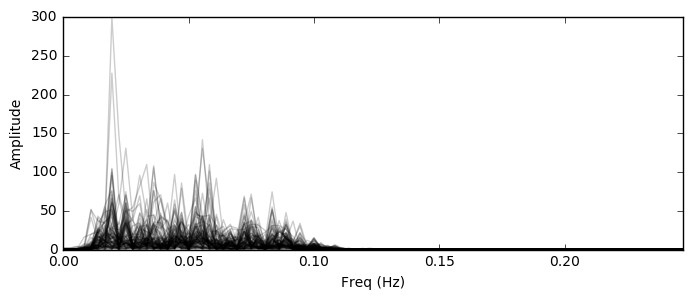

In [359]:
w = AT['157']
x = ATR['157']
y = ATF['157']
f0,a = subplots(1, figsize=(8,3)); a.plot(w, 'k', alpha=1/5.); title('Raw'); close(f0)
f1,a = subplots(1, figsize=(8,3)); a.plot(x, 'k', alpha=1/5.); title('- mean'); close(f1)
f2,a = subplots(1, figsize=(8,3)); a.plot(y, 'k', alpha=1/5.); title('- BPass'); close(f2)
figs = [[f0, Td.powerSpectra(w, sr=1./2, nf=1, sw=1, fs=(8,3), alpha=1/5.)], 
        [f1, Td.powerSpectra(x, sr=1./2, nf=1, sw=1, fs=(8,3), alpha=1/5.)], 
        [f2, Td.powerSpectra(y, sr=1./2, nf=1, sw=1, fs=(8,3), alpha=1/5.)]]
Td.htmlTable(figs, ind=0, fmt="%s", transf=1)

In [6]:
FT = []
for k in sorted(ATF.keys()):
    fq, tmp = Td.powerSpectra(ATF[k], sr=1./2, nf=1, sw=0, fs=(8,3), alpha=1/5., mean=True)
    FT.append(tmp.mean(0)[:tmp.shape[1]/2])
fq = fq[:len(fq)/2]

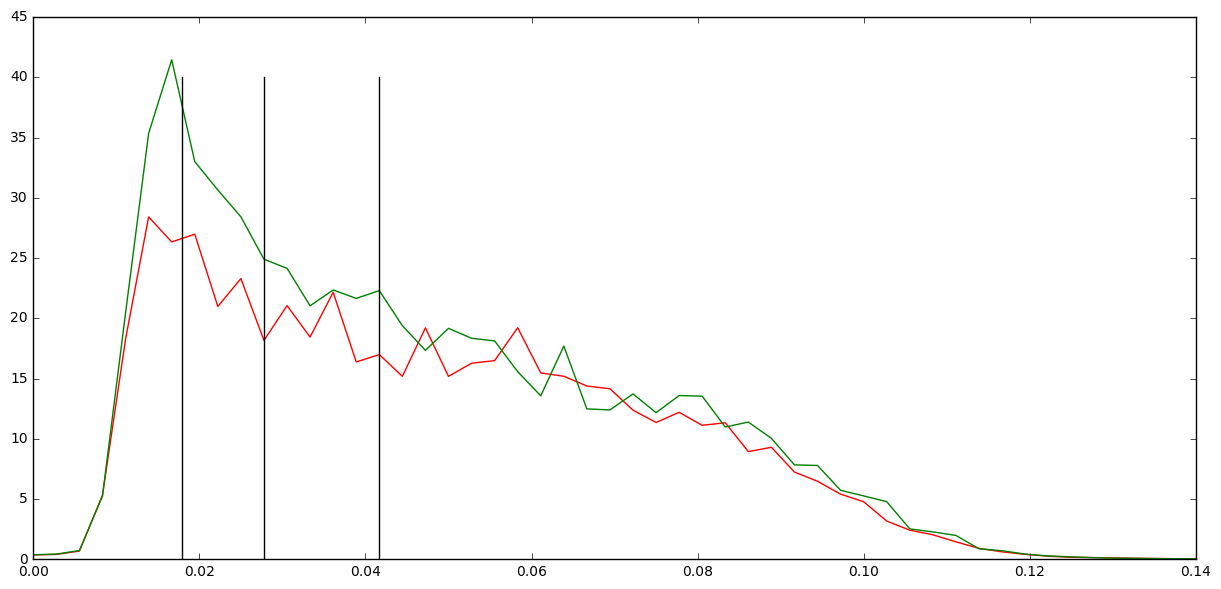

In [12]:
figure(figsize=(15,7))
plot(fq, array(FT[:18]).mean(0),'r');
plot(fq, array(FT[18:]).mean(0), 'g'); xlim(0,0.14)
plot([1/24.,1/24.],[0.01,40],'k');
plot([1/36.,1/36.],[0.01,40],'k');
plot([1/56.,1/56.],[0.01,40],'k'); 

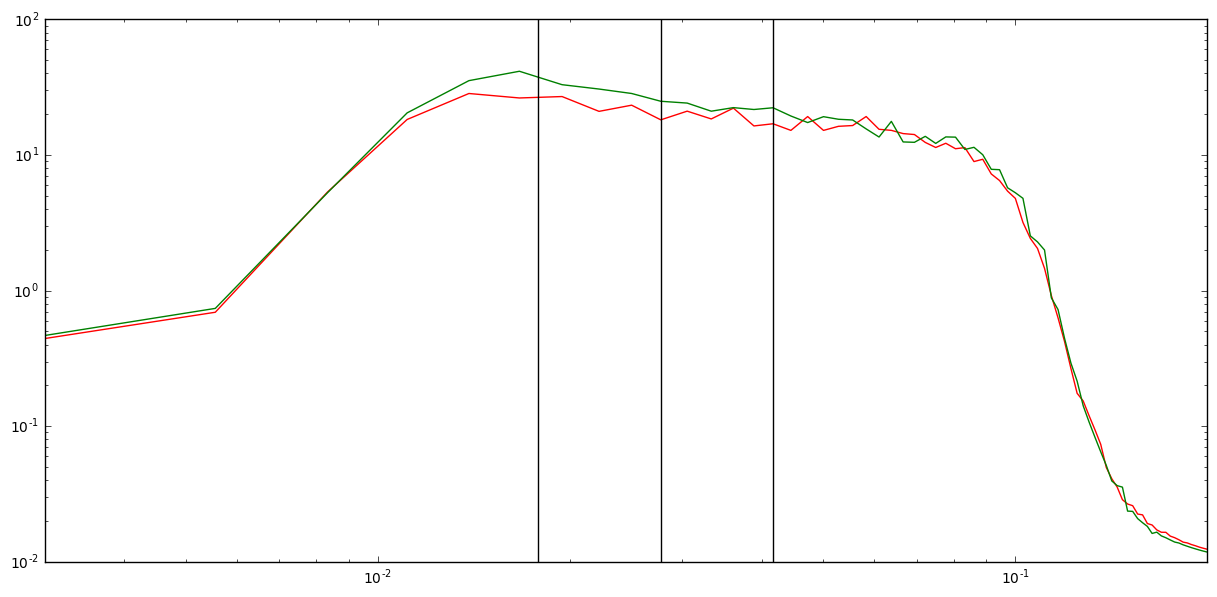

In [10]:
figure(figsize=(15,7))
loglog(fq, array(FT[:18]).mean(0),'r');
loglog(fq, array(FT[18:]).mean(0), 'g');
loglog([1/24.,1/24.],[0.01,100],'k');
loglog([1/36.,1/36.],[0.01,100],'k');
loglog([1/56.,1/56.],[0.01,100],'k'); xlim(0.003,0.2);

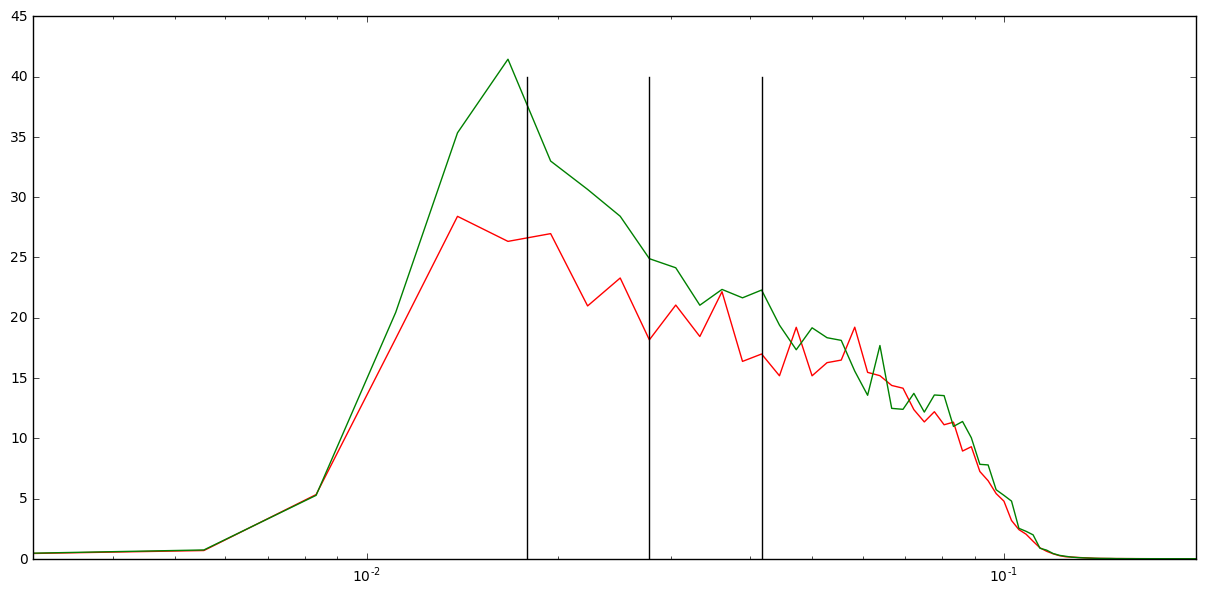

In [14]:
figure(figsize=(15,7))
semilogx(fq, array(FT[:18]).mean(0),'r');
semilogx(fq, array(FT[18:]).mean(0), 'g');
semilogx([1/24.,1/24.],[0.01,40],'k');
semilogx([1/36.,1/36.],[0.01,40],'k');
semilogx([1/56.,1/56.],[0.01,40],'k'); xlim(0.003,0.2);

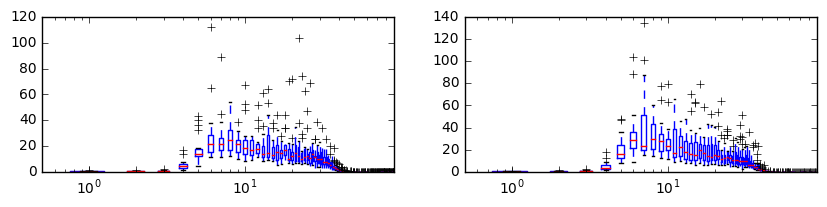

In [60]:
f,a = subplots(1,2,figsize=(10,2))
a[0].boxplot(array(FT)[:18]);
a[1].boxplot(array(FT)[18:]);
# a[0].set_yscale('log')
# a[1].set_yscale('log')
a[0].set_xscale('log')
a[1].set_xscale('log')
# a[1].set_xlim(1/20.,1/60.);
# a[1].set_ylim(6,100);
# a[0].set_xlim(1/20.,1/60.);
# a[0].set_ylim(6,100);

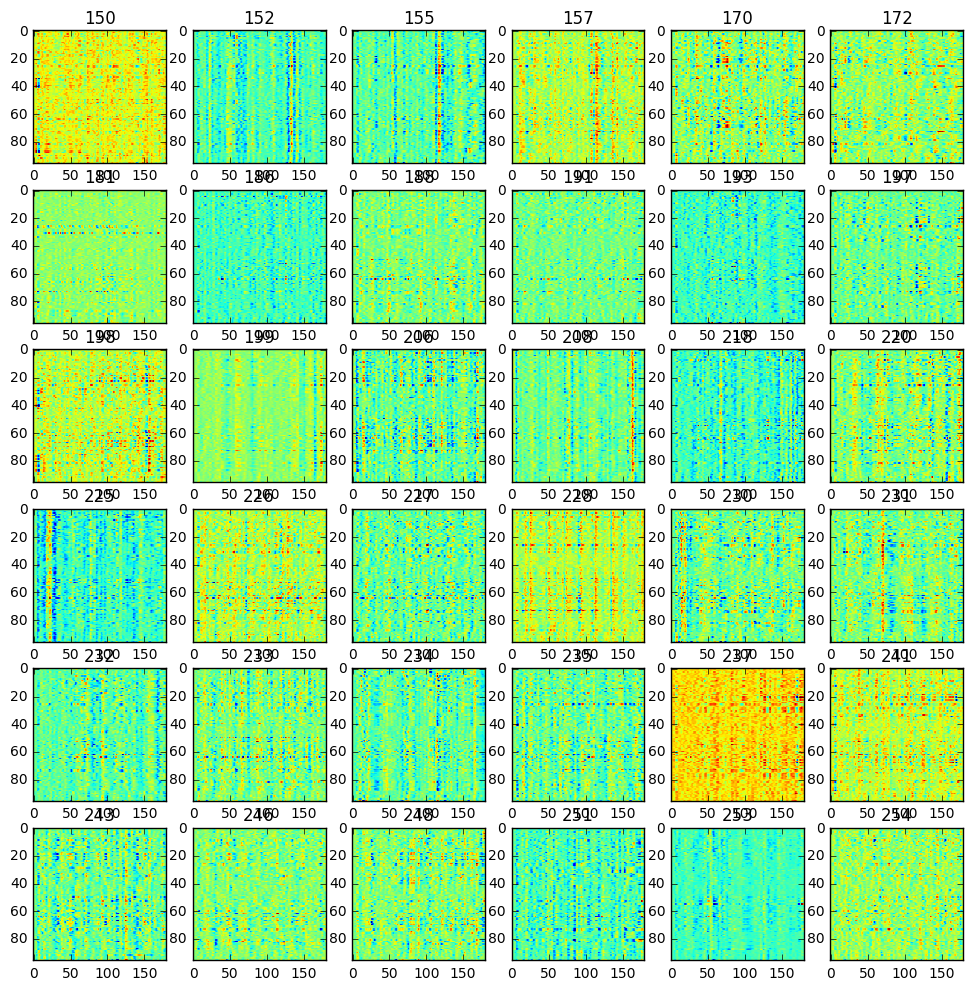

In [355]:
Td.mapMatrices([ATF[k].T for k in KS], lTitl=KS, aspect='auto', fs=(12,12), interpolation='nearest', ncl=(6,6))

# FCD

In [124]:
for k in KS:
    for w in range(4,31):
        atl = Tf.windowedFCsSym(ATF[k], window=w*2, finite=True)
        fcd = Tf.fPearsonCorrelation(atl.T)
        Te.array2data(fcd, '../Amanda/FCD/CFTL_w%.2i_%s.npy' %(w,k))
        del atl

# Analyses

In [2]:
T = len(Te.data2array('../Amanda/FCD/CFTL_w%.2i_%s.npy' %(30,150))) -3
try:
    tmp = Te.data2array('../Amanda/FCD/MEAVAR.npy', dic=1)
    dVar, dMea, VAR, MEA = tmp['dVar'], tmp['dMea'], tmp['VAR'], tmp['MEA']
except:
    dVar, dMea = zeros((2,27,36+1,T))
    VAR,MEA = zeros((2,27,36+1))
    for iw, w in enumerate(range(4,31)):
        for tau in range(T):
            for ik, k in enumerate(KS):
                cft = Te.data2array('../Amanda/FCD/CFTL_w%.2i_%s.npy' %(w,k))
                dVar[iw,ik,tau] = var( diag(cft, k=tau+1) )
                dMea[iw,ik,tau] = mean( diag(cft, k=tau+1) )
                if not tau: VAR[iw,ik] = var( Tm.triSup(cft) )
                if not tau: MEA[iw,ik] = mean( Tm.triSup(cft) )

            dVar[iw,-1,tau] = Tf.ranksums(dVar[iw,:18,tau], dVar[iw,18:-1,tau])[1]
            dMea[iw,-1,tau] = Tf.ranksums(dMea[iw,:18,tau], dMea[iw,18:-1,tau])[1]
            if not tau: VAR[iw,-1] = Tf.ranksums(VAR[iw,:18], VAR[iw,18:-1])[1]
            if not tau: MEA[iw,-1] = Tf.ranksums(MEA[iw,:18], MEA[iw,18:-1])[1]
    Te.array2data({'dVar':dVar, 'dMea':dMea, 'MEA':MEA, 'VAR':VAR}, '../Amanda/FCD/MEAVAR.npy')

In [3]:
from matplotlib import colors
cmap = colors.ListedColormap(['beige','seagreen','darkorange','firebrick'])
bounds = [0,0.01,0.05,0.1,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

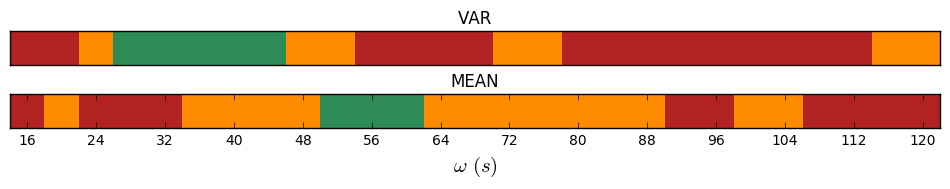

In [154]:
Td.mapMatrices([[VAR[:,-1]],[MEA[:,-1]]], lTitl=['VAR','MEAN'],
               ncl=(1,2), fs=(12,1.5), cmap=cmap, norm=norm, aspect='1', interpolation='nearest',
               lxy=[linspace(4*4, 30*4, 27).astype(int), []], lxystep=[2,None], 
               labels=[r'$\omega\ (s)$', ''], fontsize=15);

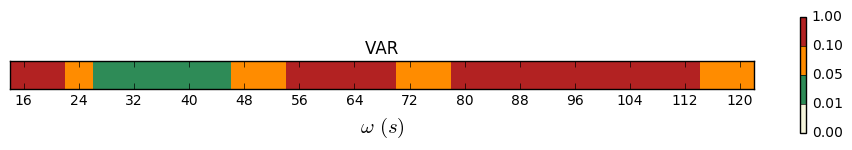

In [155]:
Td.mapMatrices([[VAR[:,-1]]], lTitl=['VAR','MEAN'],
               fs=(12,1.5), cmap=cmap, norm=norm, aspect='1', interpolation='nearest', cbar=1,
               lxy=[linspace(4*4, 30*4, 27).astype(int), []], lxystep=[2,None], 
               labels=[r'$\omega\ (s)$', ''], fontsize=15);

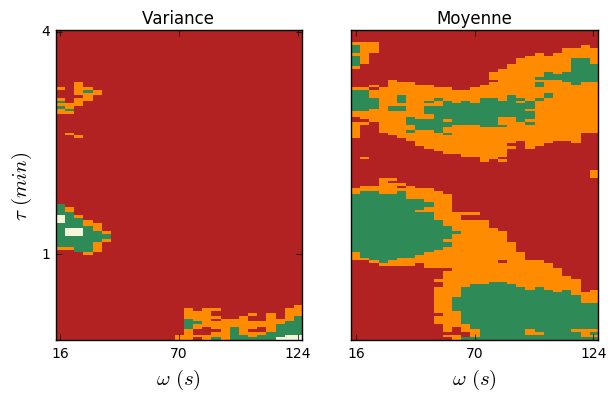

In [156]:
Td.mapMatrices(array([dVar[:,-1,::-1].T,dMea[:,-1,::-1].T]), lTitl=['Variance','Moyenne'],
               ncl=(2,1), lign=1, fs=(7,4), cmap=cmap, norm=norm, aspect='auto', vmax=1, vmin=0, interpolation='nearest',
#                lxy=[linspace(0, T*3.6/60., T).astype(int), range(4,31)], lxystep=[167,6], 
               lxy=[linspace(4*4, 31*4, 27).astype(int), linspace(4*2/60, (T+4)*2/60., T).astype(int)[::-1]], lxystep=[13,84], 
               labels=[r'$\omega\ (s)$', r'$\tau\ (min)$'], fontsize=15);

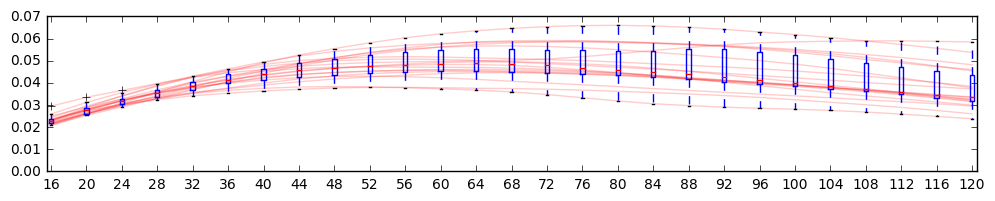

In [131]:
t = linspace(4*4, 30*4, 27).astype(int)
fig = figure(figsize=(12,2)) ; plot(t,VAR[:,:18], color='r', alpha=0.2) ; boxplot(VAR[:,:18].T,positions=t) ; ylim([0,0.07]);

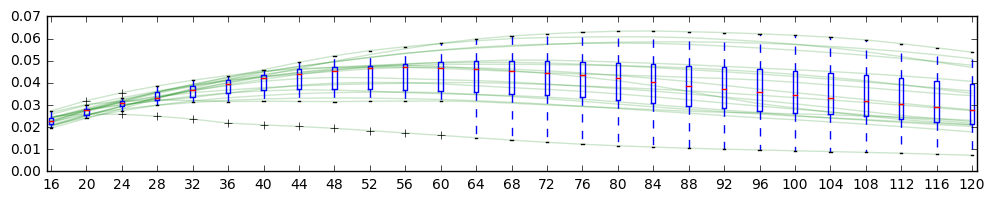

In [132]:
fig = figure(figsize=(12,2)) ; plot(t,VAR[:,18:-1], color='g', alpha=0.2) ; boxplot(VAR[:,18:-1].T,positions=t) ; ylim([0,0.07]);

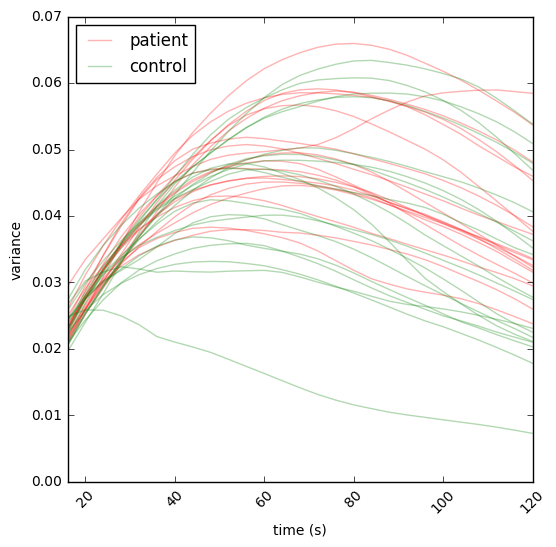

In [146]:
t = linspace(4*4, 30*4, 27).astype(int)
fig = figure(figsize=(6,6))
plot(t,VAR[:,0], color='r', alpha=0.3, label='patient')
plot(t,VAR[:,1:18], color='r', alpha=0.3)
plot(t,VAR[:,18], color='g', alpha=0.3, label='control')
plot(t,VAR[:,19:-1], color='g', alpha=0.3)
ylim([0,0.07]) ; xticks(rotation=45); legend(loc=2); xlabel('time (s)'); ylabel('variance'); xlim(4*4, 30*4); 

In [128]:
Te.array2data(VAR[:,:-1], 'tmpA.npy')

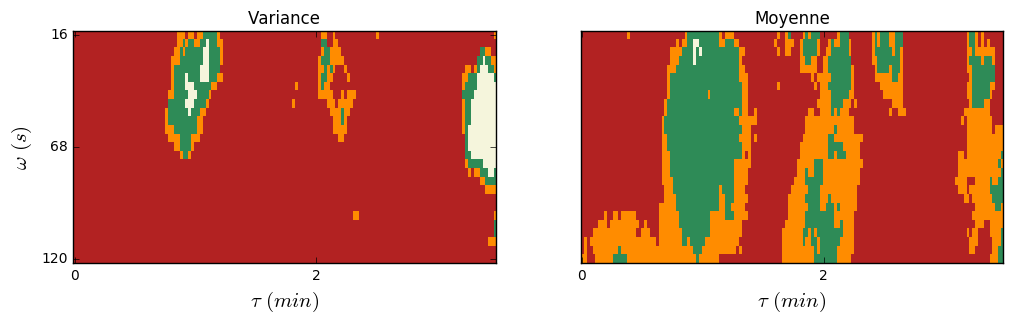

In [97]:
Td.mapMatrices(array([dVar[:,-1],dMea[:,-1]]), lTitl=['Variance','Moyenne'],
               ncl=(2,1), lign=1, fs=(12,3), cmap=cmap, norm=norm, aspect='auto', vmax=1, vmin=0, interpolation='nearest',
               lxy=[linspace(4*2/60, (T+4)*2/60., T).astype(int), linspace(4*2*2, 30*2*2, 27).astype(int)], lxystep=[84,13], 
               labels=[r'$\tau\ (min)$', r'$\omega\ (s)$'], fontsize=15);